<a href="https://colab.research.google.com/github/devpranoy/video_coloriser/blob/master/Pytorch_Video_Coloriser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Video Coloriser 

Step1

*   Download the model weights
*   Download the video to be colored

Step 2 

*   Preprocessing
*   split into frames



In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


Using pretrained weights

In [2]:
!git clone https://github.com/devpranoy/video_coloriser coloriser

fatal: destination path 'coloriser' already exists and is not an empty directory.


In [3]:

%cd coloriser
!pip install -e .

/content/coloriser
Obtaining file:///content/coloriser
  Found existing installation: fastai 0.7.0
    Can't uninstall 'fastai'. No files were found to uninstall.
  Running setup.py develop for fastai


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [5]:
# Work around with Pillow being preinstalled on these Colab VMs, causing conflicts otherwise.
!pip install Pillow==4.1.1

In [0]:
import os
from google.colab import auth
from oauth2client.client import GoogleCredentials
import multiprocessing
from torch import autograd
from fastai.transforms import TfmType
from fasterai.transforms import *
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.callbacks import *
from fasterai.loss import *
from fasterai.modules import *
from fasterai.training import *
from fasterai.generators import *
from fastai.torch_imports import *
from fasterai.filters import *
from pathlib import Path
from itertools import repeat
from google.colab import drive
from IPython.display import Image
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

# Downloading pretrained weights from dropbox

In [0]:
url = "https://www.dropbox.com/s/7r2wu0af6okv280/colorize_gen_192.h5?dl=1"  
import urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()
 
with open("pretrained_weights.h5", "wb") as f :
    f.write(data)

In [0]:
!mkdir colorised_frames

In [9]:
weights_path ='/content/coloriser/pretrained_weights.h5'
results_dir='/content/coloriser/colorised_frames'
#The higher the render_factor, the more GPU memory will be used and generally images will look better.  
#11GB can take a factor of 42 max.  Performance generally gracefully degrades with lower factors, 
#though you may also find that certain images will actually render better at lower numbers.  
#This tends to be the case with the oldest photos.
render_factor=42
filters = [Colorizer34(gpu=0, weights_path=weights_path)]
vis = ModelImageVisualizer(filters, render_factor=render_factor, results_dir=results_dir)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 90052115.16it/s]


# Upload the target video

You can either download the video from youtube or upload a video from the sidebar


If its a youtube video, then copy the youtube video link and goto https://www.onlinevideoconverter.com/ and past the video link and then copy link url from the blue download button and paste it in the cell below replacing the "https://s37.onlinevideoconverter.com/download?file=h7f5h7b1e4e4c2c2" 

In [12]:
!wget "https://s37.onlinevideoconverter.com/download?file=h7f5h7b1e4e4c2c2" -O "/content/video1.mp4"

--2019-01-29 21:16:42--  https://s37.onlinevideoconverter.com/download?file=h7f5h7b1e4e4c2c2
Resolving s37.onlinevideoconverter.com (s37.onlinevideoconverter.com)... 176.9.40.247
Connecting to s37.onlinevideoconverter.com (s37.onlinevideoconverter.com)|176.9.40.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9402704 (9.0M) [video/mp4]
Saving to: ‘/content/video1.mp4’

/content/video1.mp4 100%[===================>]   8.97M  3.42MB/s    in 2.6s    

2019-01-29 21:16:46 (3.42 MB/s) - ‘/content/video1.mp4’ saved [9402704/9402704]



# Converting a black and white video to frames

In [0]:
!mkdir frames

In [0]:
import cv2
vidcap = cv2.VideoCapture('/content/video1.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/coloriser/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

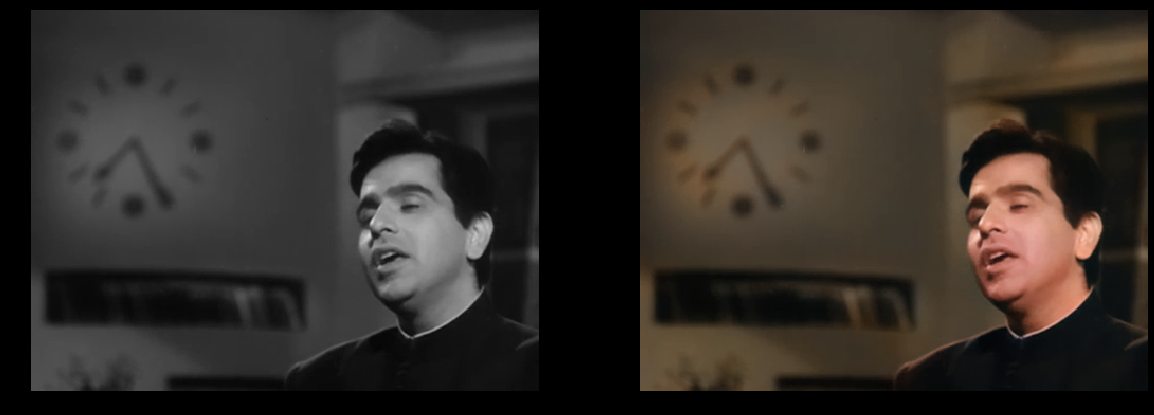

In [19]:
#testing a random frame to optimise render factor/
vis.plot_transformed_image('/content/coloriser/frames/frame56.jpg', render_factor=40)

In [0]:
! rm -rf colorised_frames
! mkdir colorised_frames

In [0]:
import glob
frames = glob.glob("/content/coloriser/frames/*.jpg")


In [22]:
try:
  for i in range(len(frames)):
    vis.frame_transformed_image(frames[i], render_factor=40)
    if i%100 == 0:
      print("%d out of %d"%(i,len(frames)))
      os.system('cls' if os.name == 'nt' else "printf '\033c'")
except:
  print("Final Frame processed")
  
#it gives out some error on the final frame if not in a try catch block. Ignore the error
  

0 out of 4921
100 out of 4921
Final Frame processed


# Converting colored frames to video

In [0]:

import cv2
import numpy as np
import os
 
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
    
pathIn = '/content/coloriser/colorised_frames/'
pathOut = '/content/coloriser/video_colorised.avi'
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)
print("Completed. Dowload the video from the left navigator under the files section")

Completed. Dowload the video from the left navigator under the files section
